In [71]:
import numpy as np
import pandas as pd

In [72]:
sent_data = pd.read_csv("../data/processed/daily_sentiment_news_2017_2025.csv")
sp500_returns = pd.read_csv("../data/processed/SP500_returns.csv")
print(sp500_returns.head())

sp500_returns["date"] = pd.to_datetime(sp500_returns["date"]).dt.normalize()

if "market_date" in sent_data.columns: 
    sent_data = sent_data.rename(columns={"market_date": "date"}) 
elif "date" not in sent_data.columns: 
    raise ValueError(f"Expected 'market_date' or 'date' in sent file. Found: {sent_data.columns.tolist()}")

sent_data["date"] = pd.to_datetime(sent_data["date"], errors="coerce").dt.tz_localize(None).dt.normalize()

mixed_data = sp500_returns.merge(sent_data, on="date", how="left").sort_values("date")

print(mixed_data.head())
mixed_data.to_csv("../data/processed/mixed_data.csv")


         date      Price    Return
0  2017-01-03  2257.8301       NaN
1  2017-01-04  2270.7500  0.005706
2  2017-01-05  2269.0000 -0.000771
3  2017-01-06  2276.9800  0.003511
4  2017-01-09  2268.8999 -0.003555
        date      Price    Return  sent_mean  sent_median  sent_std  \
0 2017-01-03  2257.8301       NaN   0.249078     0.249078  0.000000   
1 2017-01-04  2270.7500  0.005706   0.076594     0.052622  0.050993   
2 2017-01-05  2269.0000 -0.000771        NaN          NaN       NaN   
3 2017-01-06  2276.9800  0.003511        NaN          NaN       NaN   
4 2017-01-09  2268.8999 -0.003555        NaN          NaN       NaN   

   news_count  frac_neg  frac_pos  frac_neu   sent_se  
0         1.0       0.0       1.0       0.0  0.000000  
1         7.0       0.0       0.0       1.0  0.019274  
2         NaN       NaN       NaN       NaN       NaN  
3         NaN       NaN       NaN       NaN       NaN  
4         NaN       NaN       NaN       NaN       NaN  


In [73]:
base_features = ["sent_mean", "sent_median", "sent_std", "news_count", "frac_neg", "frac_pos", "frac_neu"]

# Fill missing sentiment with neutral-ish defaults
# (so trading days without news don't become NaN and get dropped)
# mixed_data["has_news"] = (mixed_data["news_count"].notna()).astype(int)

mixed_data["news_count"] = mixed_data["news_count"].fillna(0)

for value in ["sent_mean", "sent_median", "sent_std", "news_count", "frac_neg", "frac_pos", "frac_neu"]:
    mixed_data[value] = mixed_data[value].fillna(0.0)
    
#lags = [1,2,5]
#for col in ["Return", "sent_mean", "sent_median", "news_count", "frac_neg", "frac_pos", "frac_neu"]:
#    for lag in lags:
#        mixed_data[f"{col}_lag{lag}"] = mixed_data[col].shift(lag)

X = mixed_data[["date","Return", "sent_mean", "news_count", "frac_neg"]].copy()

lags = [1,2,5]
for col in ["Return", "sent_mean", "news_count", "frac_neg"]:
    for lag in lags:
        X[f"{col}_lag{lag}"] = X[col].shift(lag)
   
X.head()

,date,Return,sent_mean,news_count,frac_neg,Return_lag1,Return_lag2,Return_lag5,sent_mean_lag1,sent_mean_lag2,sent_mean_lag5,news_count_lag1,news_count_lag2,news_count_lag5,frac_neg_lag1,frac_neg_lag2,frac_neg_lag5
0,2017-01-03,NaN,0.249078,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-04,0.005706,0.076594,7.0,0.0,NaN,NaN,NaN,0.249078,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN
2,2017-01-05,-0.000771,0.000000,0.0,0.0,0.005706,NaN,NaN,0.076594,0.249078,NaN,7.0,1.0,NaN,0.0,0.0,NaN
3,2017-01-06,0.003511,0.000000,0.0,0.0,-0.000771,0.005706,NaN,0.000000,0.076594,NaN,0.0,7.0,NaN,0.0,0.0,NaN
4,2017-01-09,-0.003555,0.000000,0.0,0.0,0.003511,-0.000771,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN,0.0,0.0,NaN


In [74]:
X.set_index("date", inplace=True)
X["vol_30"] = X["Return"].rolling(5).std().shift(1)
X.head()

,Return,sent_mean,news_count,frac_neg,Return_lag1,Return_lag2,Return_lag5,sent_mean_lag1,sent_mean_lag2,sent_mean_lag5,news_count_lag1,news_count_lag2,news_count_lag5,frac_neg_lag1,frac_neg_lag2,frac_neg_lag5,vol_30
date,,,,,,,,,,,,,,,,,
2017-01-03,NaN,0.249078,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.005706,0.076594,7.0,0.0,NaN,NaN,NaN,0.249078,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN
2017-01-05,-0.000771,0.000000,0.0,0.0,0.005706,NaN,NaN,0.076594,0.249078,NaN,7.0,1.0,NaN,0.0,0.0,NaN,NaN
2017-01-06,0.003511,0.000000,0.0,0.0,-0.000771,0.005706,NaN,0.000000,0.076594,NaN,0.0,7.0,NaN,0.0,0.0,NaN,NaN
2017-01-09,-0.003555,0.000000,0.0,0.0,0.003511,-0.000771,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN


In [75]:
y = X['Return']
X = X.shift(1)

X = X.dropna()
y = y.reindex(X.index)

print(X.head())
print(y.head())


              Return  sent_mean  news_count  frac_neg  Return_lag1  \
date                                                                 
2017-01-12  0.002826   0.000000         0.0       0.0     0.000000   
2017-01-13 -0.002147   0.000000         0.0       0.0     0.002826   
2017-01-17  0.001848   0.000000         0.0       0.0    -0.002147   
2017-01-18 -0.002972   0.000000         0.0       0.0     0.001848   
2017-01-19  0.001762   0.029474         1.0       0.0    -0.002972   

            Return_lag2  Return_lag5  sent_mean_lag1  sent_mean_lag2  \
date                                                                   
2017-01-12    -0.003555     0.005706             0.0             0.0   
2017-01-13     0.000000    -0.000771             0.0             0.0   
2017-01-17     0.002826     0.003511             0.0             0.0   
2017-01-18    -0.002147    -0.003555             0.0             0.0   
2017-01-19     0.001848     0.000000             0.0             0.0   

    

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

from ngboost import NGBoost
from ngboost.distns import T
from ngboost.scores import LogScore


def run_expanding_backtest_ngboost(X, y, start_test_idx, var_levels=(0.95, 0.99), es_mc_samples=3000):
    model = NGBoost(
        Dist=T,
        Score=LogScore,
        Base=DecisionTreeRegressor(max_depth=2, min_samples_leaf=50),
        learning_rate=0.01,
        n_estimators=200,
        natural_gradient=False,
        verbose=True,
        random_state=42,
    )
    rows = []

    X_vals = X.values
    y_vals = y.values
    idx = X.index
    n = len(X_vals)

    for t in range(start_test_idx, n):
        # Expanding window: train on everything up to t-1
        window = 252   
        start = max(0, t - window)
        X_train = X.iloc[start:t].values
        y_train = y.iloc[start:t].values 

        X_test = X_vals[t:t+1]
        y_test = float(y_vals[t])

        # Standardize X
        scaler_X = StandardScaler()
        X_train_std = scaler_X.fit_transform(X_train)
        X_test_std  = scaler_X.transform(X_test)

        # Standardize y
        scaler_y = StandardScaler()
        y_train_std = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model.fit(X_train_std, y_train_std)
        dist = model.pred_dist(X_test_std)

        out = {"Date": idx[t], "y_real": y_test}

        # Optional: store distribution mean/sigma in original units
        mu_z = float(dist.mean()[0])
        sig_z = float(np.sqrt(dist.var[0]))
        out["mu_pred"] = float(scaler_y.inverse_transform([[mu_z]])[0, 0])
        out["sigma_pred"] = float(scaler_y.scale_[0] * sig_z)

        for a in var_levels:
            q = 1 - a  # left-tail probability (e.g. 0.01 for 99% VaR)

            var_z = float(np.asarray(dist.ppf(q)).reshape(-1)[0])

            samples_z = dist.sample(es_mc_samples).reshape(-1)
            es_z = float(samples_z[samples_z <= var_z].mean())

            out[f"VaR_{int(a*100)}"] = float(scaler_y.inverse_transform([[var_z]])[0, 0])
            out[f"ES_{int(a*100)}"]  = float(scaler_y.inverse_transform([[es_z]])[0, 0])

        rows.append(out)

    return pd.DataFrame(rows).set_index("Date")

In [77]:
start_test_idx = 252 * 3

res_sent = run_expanding_backtest_ngboost(
    X,
    y,
    start_test_idx=start_test_idx,
    var_levels=[0.95, 0.99],
    es_mc_samples=3000
)

[iter 0] loss=1.3712 val_loss=0.0000 scale=1.0000 norm=1.4827
[iter 100] loss=1.2603 val_loss=0.0000 scale=1.0000 norm=1.4873
[iter 0] loss=1.3687 val_loss=0.0000 scale=1.0000 norm=1.4871
[iter 100] loss=1.2562 val_loss=0.0000 scale=1.0000 norm=1.4914
[iter 0] loss=1.3706 val_loss=0.0000 scale=1.0000 norm=1.4834
[iter 100] loss=1.2596 val_loss=0.0000 scale=1.0000 norm=1.4881
[iter 0] loss=1.3693 val_loss=0.0000 scale=1.0000 norm=1.4860
[iter 100] loss=1.2572 val_loss=0.0000 scale=1.0000 norm=1.4910


KeyboardInterrupt: 

In [ ]:
res_sent.to_csv("../data/processed/sentiment_results.csv")

Violation rate 95: 0.07827788649706457
Violation rate 99: 0.012393998695368558


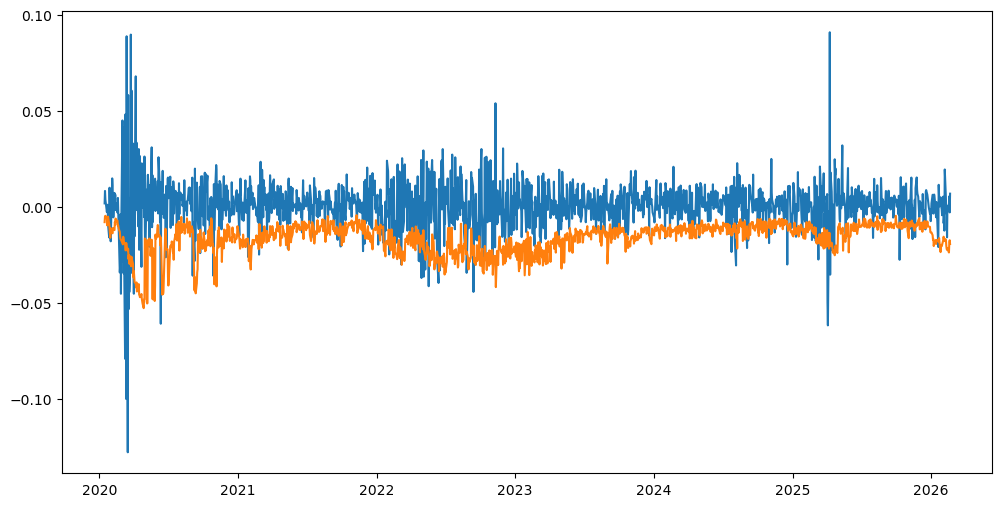

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(res_sent["y_real"], label = "Return")
plt.plot(res_sent["VaR_95"], label = "VaR_95")

res_sent["violation_95"] = (res_sent["y_real"] < res_sent["VaR_95"]).astype(int)
res_sent["violation_99"] = (res_sent["y_real"] < res_sent["VaR_99"]).astype(int)

violation_rate_95 = res_sent["violation_95"].mean()
violation_rate_99 = res_sent["violation_99"].mean()

print("Violation rate 95:", violation_rate_95)
print("Violation rate 99:", violation_rate_99)